In [1]:
!pip install -q -U google-generativeai pandas scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 44.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.


In [2]:
import google.generativeai as genai
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
GOOGLE_API_KEY = 'removendo api por questao de seguranca'
genai.configure(api_key=GOOGLE_API_KEY)

In [6]:
# from google.colab import userdata
# try:
#     GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
# except:
#     GOOGLE_API_KEY = input("Cole sua Google API Key aqui: ")

# genai.configure(api_key=GOOGLE_API_KEY)

Cole sua Google API Key aqui: removendo a minha api


In [13]:
# @title Carregando o Dataset de Fraude
url_fraud = 'https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv'
df_fraud = pd.read_csv(url_fraud)

In [14]:
df_fraud.shape

(284807, 31)

In [9]:
df_fraud.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
270625,164174.0,-2.413054,1.713812,-0.873060,-2.481167,1.979927,3.827216,-0.296690,0.953270,2.006181,...,-0.312121,-0.634793,0.131188,0.640817,0.027632,-0.354056,-0.606756,-0.093892,3.70,0
483,355.0,1.085840,0.126686,0.498972,1.333700,-0.199129,0.032644,-0.015574,0.116091,0.015999,...,-0.029953,0.087509,-0.059209,0.245501,0.601876,-0.344061,0.034199,0.009880,19.64,0
177983,123423.0,-0.489117,0.199529,1.481093,-0.498933,0.868933,0.524534,0.305167,0.024468,0.059714,...,0.315831,1.070707,-0.284041,0.259659,0.056139,-0.465302,0.011366,-0.071124,31.50,0
134774,80957.0,-1.600211,-0.612738,3.106870,3.304341,1.329700,2.683346,-1.386640,1.206106,-0.463393,...,0.036082,0.300822,0.141009,-0.974419,-0.163858,0.334574,0.171194,0.097113,16.70,0
62297,50218.0,1.274382,-0.154771,-0.672002,-0.231597,0.379256,-0.029279,0.144433,-0.053420,0.236767,...,-0.130957,-0.469229,-0.202685,-1.270804,0.491023,1.123548,-0.102265,-0.015476,52.39,0


In [10]:
# @title Análise Exploratória (EDA)
df_fraud['Class'].value_counts()

,count
Class,
0,284315
1,492


In [11]:
# Normalização
df_fraud['Class'].value_counts(normalize=True)

,proportion
Class,
0,0.998273
1,0.001727


In [15]:
# @title Modelo Baseline: Treinando nos Dados Originais

X = df_fraud.drop('Class', axis=1)
y = df_fraud['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

model = LogisticRegression()

model.fit(X_train, y_train)

y_pred_baseline = model.predict(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [16]:
# Report de classificação
print(classification_report(y_test, y_pred_baseline))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85313
           1       0.77      0.76      0.76       130

    accuracy                           1.00     85443
   macro avg       0.88      0.88      0.88     85443
weighted avg       1.00      1.00      1.00     85443



<Axes: >

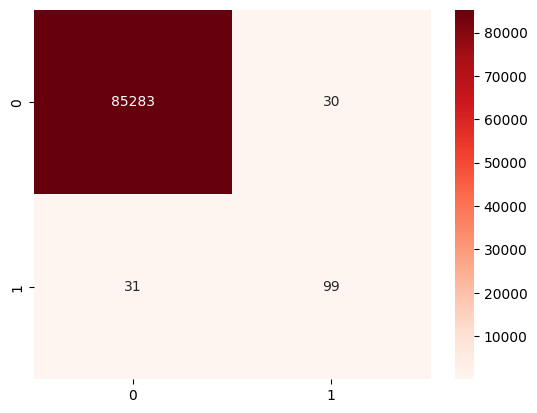

In [18]:
# Matriz de Confusão
sns.heatmap(confusion_matrix(y_test, y_pred_baseline),annot=True,fmt='d',cmap='Reds')

In [25]:
# @title Usando IA Generativa para Criar Dados Sintéticos
df_fraudes_reais = X_train[y_train == 1].sample(5) #5 exemp de fraudes

exemplos_texto = '' # format exempos para o prompt

for i, row in df_fraudes_reais.iterrows():
  exemplos_texto += f"exemplo de transação fraudulenta {i+1}:\n"
  exemplos_texto += str(row.to_dict()) + "\n"

prompt_geracao = f"""
Você é um especialista em ciência de dados simulando dados para um modelo de detecção de fraude.
Com base nos exemplos de transações fraudulentas abaixo, gere 10 novos exemplos de transações fictícias, mas realistas, que sigam um padrão similar.
Retorne apenas os dicionários de dados, um por linha, sem texto adicional.

{exemplos_texto}

Gere 10 novos exemplos aqui:
"""

In [34]:
# create/use generative AI model
model_gen = genai.GenerativeModel('gemini-2.5-flash')
response = model_gen.generate_content(prompt_geracao)

In [36]:
novas_fraudes = []
for line in response.text.strip().split('\n'):
  try:
    novas_fraudes.append(ast.literal_eval(line))
  except:
    continue

df_novas_fraudes = pd.DataFrame(novas_fraudes)

In [38]:
df_novas_fraudes['Class'] = 1

In [39]:
df_novas_fraudes

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,56789.0,-25.123457,15.678901,-30.987654,9.123457,-20.010203,-4.567890,-18.765432,18.901235,-5.101112,...,2.543211,-1.987654,-0.876543,0.345679,-0.012346,-0.156789,-2.123457,-0.678901,112.45,1
1,101234.0,1.543211,1.876543,-5.123457,2.543211,-2.101112,-3.012346,-3.543211,0.543211,-1.567890,...,0.543211,-1.012346,0.054321,-0.345679,0.123457,-0.187654,0.876543,0.432110,72.80,1
2,145678.0,-18.765432,10.123457,-25.987654,8.543211,-15.678901,-3.876543,-12.345679,12.012346,-4.876543,...,2.123457,0.432110,-0.543211,0.234568,-0.056789,-0.087654,-1.876543,-0.543211,95.50,1
3,32109.0,-32.123457,17.876543,-33.987654,7.123457,-24.567890,-5.123457,-21.012346,21.543211,-3.987654,...,1.987654,-2.543211,-1.234568,0.156789,2.123457,-0.254321,1.345679,0.456789,100.01,1
4,88888.0,0.876543,1.012346,-2.543211,3.123457,0.876543,-1.012346,0.123457,-0.056789,-0.987654,...,-0.156789,-0.543211,0.123457,-0.187654,-0.087654,-0.156789,-0.001235,0.001235,5.25,1
5,75123.0,-15.543211,9.876543,-22.123457,6.876543,-13.012346,-4.012346,-10.543211,10.123457,-3.543211,...,1.876543,-0.876543,-0.678901,0.301235,-0.234568,-0.087654,-1.987654,-0.601235,88.00,1
6,123456.0,-10.123457,6.543211,-15.876543,5.123457,-9.876543,-2.876543,-8.123457,7.543211,-3.012346,...,1.543211,-0.543211,-0.432110,0.187654,-0.101235,-0.054321,-1.543211,-0.456789,60.15,1
7,45678.0,-28.987654,16.012346,-32.543211,6.876543,-21.543211,-4.876543,-19.543211,19.876543,-3.765432,...,1.876543,-2.123457,-1.345679,0.201235,2.012346,-0.187654,1.123457,0.387654,99.00,1
8,110110.0,0.678901,1.123457,-3.123457,2.012346,-1.543211,-2.012346,-2.543211,0.345679,-1.123457,...,0.432110,-0.987654,0.087654,-0.254321,0.054321,-0.123457,0.765432,0.354321,68.50,1
9,98765.0,-11.543211,8.123457,-19.012346,7.012346,-10.543211,-3.543211,-13.012346,7.876543,-4.012346,...,2.765432,0.543211,-0.678901,0.387654,-0.087654,-0.056789,-2.234568,-0.654321,108.10,1


In [40]:
# @title Modelo Aprimorado: Treinando com os Dados Aumentados

print("\n--- 🚀 Treinando nosso Modelo Aprimorado com Dados Sintéticos ---")
X_train_aumentado = pd.concat([X_train, df_novas_fraudes.drop('Class', axis=1)], ignore_index=True)
y_train_aumentado = pd.concat([y_train, df_novas_fraudes['Class']], ignore_index=True)

model_melhorado = LogisticRegression()
model_melhorado.fit(X_train_aumentado, y_train_aumentado)
y_pred_melhorado = model_melhorado.predict(X_test)


--- 🚀 Treinando nosso Modelo Aprimorado com Dados Sintéticos ---


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [41]:
# @title Comparando resultados

print("\n--- Resultado do Modelo Baseline ---")
print(classification_report(y_test, y_pred_baseline))

print("\n--- Resultado do Modelo Aprimorado ---")
print(classification_report(y_test, y_pred_melhorado))


--- Resultado do Modelo Baseline ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85313
           1       0.77      0.76      0.76       130

    accuracy                           1.00     85443
   macro avg       0.88      0.88      0.88     85443
weighted avg       1.00      1.00      1.00     85443


--- Resultado do Modelo Aprimorado ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85313
           1       0.78      0.78      0.78       130

    accuracy                           1.00     85443
   macro avg       0.89      0.89      0.89     85443
weighted avg       1.00      1.00      1.00     85443



Text(0.5, 1.0, 'Matriz de Confusão - Modelo Aprimorado com GenAI')

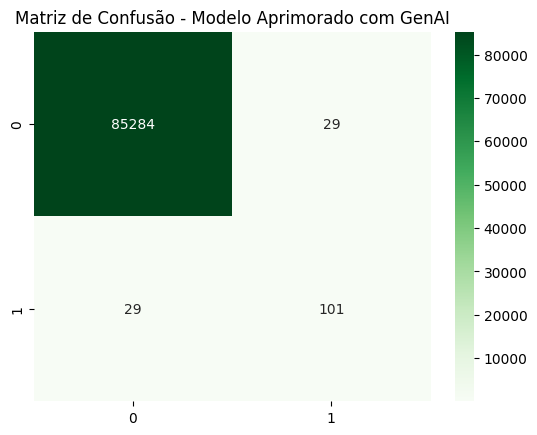

In [43]:
sns.heatmap(confusion_matrix(y_test, y_pred_melhorado), annot=True, fmt='d', cmap='Greens')
plt.title('Matriz de Confusão - Modelo Aprimorado com GenAI')